In [11]:
# 将字符串列表转换为整数列表
string_numbers = input().split()
int_numbers = list(map(int, string_numbers))

print("List of integers:", int_numbers)

List of integers: [1, 2, 3]


In [15]:
line = int(input())
for i in range(line):
    print(" "*(line-i-1),end="")
    print("*"*(i+1))

*


### Transformer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [11]:
# 划分数据集
def split_dataset(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # normal data
    X_normal = X[Y == 0]
    Y_normal = Y[Y == 0]

    # abnormal data
    X_abnormal = X[Y == 1]
    Y_abnormal = Y[Y == 1]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_normal, Y_normal, test_size=0.2, random_state=2023)
    
    # 拼接X_test和X_abnormal
    X_test = np.concatenate((X_test, X_abnormal), axis=0)
    y_test = np.concatenate((y_test, Y_abnormal), axis=0)

    # # 将时间序列数据转换为适用于LSTM自编码器的输入格式
    # X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    # X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train, X_test, y_train, y_test

from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
def pick_threshold(y, preds):
    thresholds = np.linspace(0, 1, 500)
    f1_scores = [f1_score(y, preds > t) for t in thresholds]
    precision_scores = [precision_score(y, preds > t) for t in thresholds]
    recall_scores = [recall_score(y, preds > t) for t in thresholds]
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.axvline(x=thresholds[np.argmax(f1_scores)], color='r', linestyle='--', label='Max F1 Score')
    plt.title('F1 Score w.r.t varying threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    best_threshold = thresholds[np.argmax(f1_scores)]
    print('Best threshold: ', best_threshold)
    print('Best F1 Score: ', np.max(f1_scores))
    print('Recall: ', recall_score(y, preds > best_threshold))
    print('Precision: ', precision_score(y, preds > best_threshold))
    

    cm = confusion_matrix(y, preds > best_threshold)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return best_threshold

In [40]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def transformer_anomaly_detection(input_shape, num_layers, d_model, num_heads, d_ff, rate):
    """
    定义Transformer异常检测模型函数。

    参数：
    input_shape：输入序列的形状（例如，(seq_length, input_dim)）
    num_layers：Transformer模型中的编码器层数
    d_model：Transformer模型中注意力机制的维度
    num_heads：注意力头的数量
    d_ff：Transformer模型中前馈神经网络的隐藏层维度
    rate：Dropout的比例

    返回：
    anomaly_model：异常检测模型
    """
    # 输入层
    inputs = tf.keras.layers.Input(shape=input_shape)

    # 编码器部分
    x = inputs
    for _ in range(num_layers):
        x = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)(x, x)
        x = tf.keras.layers.Dropout(rate)(x)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(d_ff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        x = ffn(x)
        x = tf.keras.layers.Dropout(rate)(x)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # 使用Transformer编码器的输出来预测下一个数据点
    predictions = tf.keras.layers.Dense(input_shape[-1])(x)

    # 构建异常检测模型
    transformer = tf.keras.models.Model(inputs=inputs, outputs=predictions)

    return transformer

def train_transformer(timefreq):
    # 划分数据集
    x_train, x_test, y_train, y_test = split_dataset('5S')

    # 设置参数
    input_shape = x_train.shape[1:]  # (12,)
    num_layers = 4
    d_model = 128
    num_heads = 8
    d_ff = 512
    rate = 0.1

    # 构建Transformer异常检测模型
    transformer = transformer_anomaly_detection(input_shape, num_layers, d_model, num_heads, d_ff, rate)

    # 编译模型
    transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # 训练Transformer模型
    transformer.fit(x_train, x_train, batch_size=32, epochs=50, validation_split=0.1)

    # plot loss
    plt.plot(transformer.history.history['loss'], label='train')
    plt.plot(transformer.history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


In [41]:
train_transformer('5S')

IndexError: Exception encountered when calling layer 'softmax' (type Softmax).

tuple index out of range

Call arguments received by layer 'softmax' (type Softmax):
  • inputs=tf.Tensor(shape=(None, 8), dtype=float32)
  • mask=None

5142/5142 [==============================] - 3s 520us/step


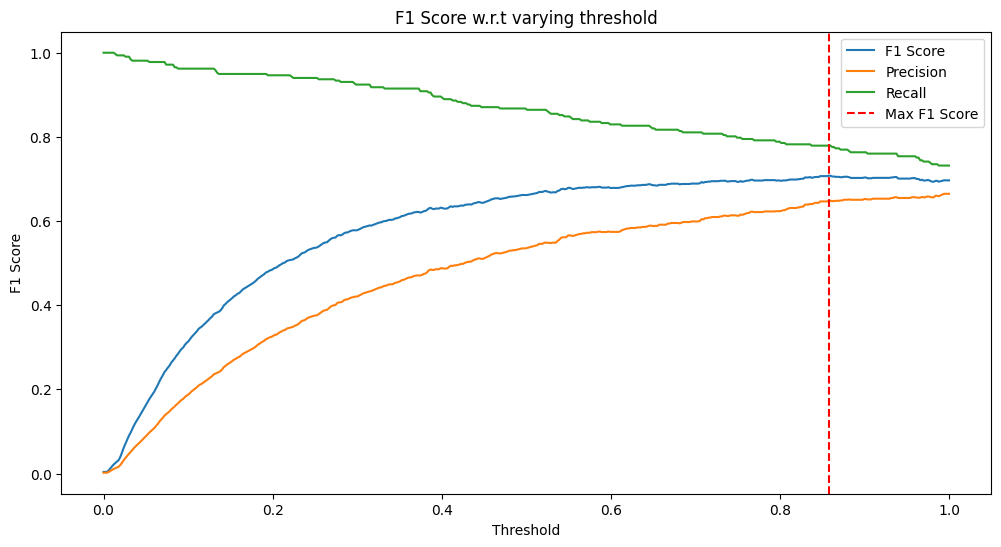

Best threshold:  0.8577154308617234
Best F1 Score:  0.7077363896848138
Recall:  0.7791798107255521
Precision:  0.6482939632545932


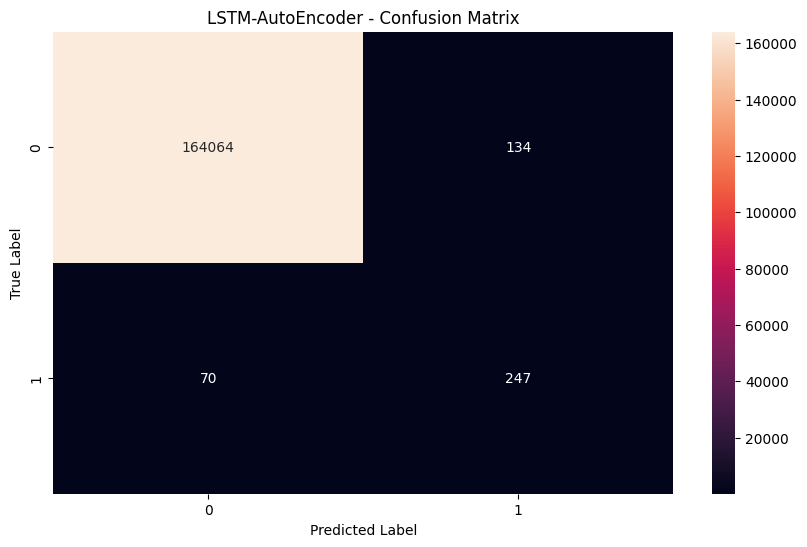

0.8577154308617234

In [13]:
x_pred = transformer.predict(x_test)
reconstruction_error = np.mean(np.square(x_test - x_pred), axis=1)
pick_threshold(y_test, reconstruction_error)

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add, Concatenate

def positional_encoding(max_position, d_model):
    angle_rads = 1 / tf.pow(10000, (2 * (tf.range(d_model, dtype=tf.float32) // 2)) / tf.cast(d_model, tf.float32))
    angle_rads = tf.reshape(angle_rads, (1, -1))
    position = tf.cast(tf.range(max_position), tf.float32)
    position = tf.reshape(position, (-1, 1))
    pos_encoding = position * angle_rads
    pos_encoding[:, 0::2] = tf.math.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = tf.math.cos(pos_encoding[:, 1::2])
    return pos_encoding

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention mechanism
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([inputs, x])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feedforward neural network
    ffn = tf.keras.Sequential(
        [Dense(ff_dim, activation="relu"), Dense(inputs.shape[-1]),]
    )
    x = ffn(x)
    x = Dropout(dropout)(x)
    x = Add()([inputs, x])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def transformer_encoder_stack(inputs, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    return x

def build_transformer_anomaly_detection_model(input_shape, max_position, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0):
    inputs = Input(shape=input_shape)
    pos_encodings = positional_encoding(max_position, input_shape[-1])
    x = inputs + pos_encodings
    x = transformer_encoder_stack(x, head_size, num_heads, ff_dim, num_transformer_blocks, dropout)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def train_transformer(timefreq):
    # 划分数据集
    x_train, x_test, y_train, y_test = split_dataset('5S')

    sequence_length = x_train.shape[0]
    feature_dim = x_train.shape[1]
    input_shape = (sequence_length, feature_dim)  # Replace with your input shape
    max_position = 100  # Define the maximum position for positional encoding
    head_size = 64
    num_heads = 4
    ff_dim = 128
    num_transformer_blocks = 2
    dropout = 0.1

    model = build_transformer_anomaly_detection_model(input_shape, max_position, head_size, num_heads, ff_dim, num_transformer_blocks, dropout)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(x_train, x_train, batch_size=32, epochs=50, validation_split=0.1)

    # plot loss
    plt.plot(model.history.history['loss'], label='train')
    plt.plot(model.history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


In [28]:
train_transformer('5S')

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment